# Music classification & generation with spectrograms

### Background
Sound can have different digital representations: usually it is stored by encoding the shape of the waveform as it changes over time, but for analysis we often make use of visually inspectable spectrograms - obtained from a waveform by computing the Fourier transform of overlapping windows of the audio signal, and stacking the results into a 2D array. These spectrograms exhibit a lot of structure, and modelling it can enable sound - in this case music - classification, generation, even recommendation for e.g. speech recognition or music recommendation.

 <br> 

### Project Ideas
1. Using networks to organize music by features such as genre. 
    - (easy) Classification: Train a CNN using spectrograms that classifies music into different genres. Fine-tune your model and test whether it generalizes well.
    - (easy) Clustering: Train a CNN using spectrograms and examine clusters of the extracted features. Visualize the results and see whether meaningful clusters emerge.
    - (medium) Pre-trained models: Use a model that has been pre-trained on natural images (e.g., ResNet) and fine-tune it for music classification.  Compare its performance to your own CNN. [see https://arxiv.org/pdf/2007.11154.pdf]
    - (medium) Vision transformers: Vision transformers can be used to replace CNNs in Computer Vision. Evaluate whether pre-trained vision transformers perform better at music classification than your own CNN. [see https://arxiv.org/abs/2010.11929]

<br> 

2. Network architecture and model improvements
    - (easy) Improve classification. Drop training examples and/or music genres that seem to be difficult to distinguish and see whether classification performance improves. Shorten the spectrograms by cropping them or splitting them in smaller parts and evaluate the effect on classification performance.
    - (medium) Augmentation: Standard image augmentation techniques might break the temporal correlations in music. Use this augmentation method (https://arxiv.org/abs/1904.08779) or come up with your own method to enhance the performance of your CNN or the pre-trained model.

<br> 
3. Advanced options 
    - (hard) Music generation: Train or finetune a generative model on spectrograms to see if it is possible to generate enjoyable music in this way. Create the audio from generated spectrograms.
    - (hard) Music recommendation: Come up with a similarity metric and try to identify similar music tracks using extracted features from your CNN or the pre-trained model. 

 <br> 

### This notebook
This notebook loads the GTZAN dataset which includes audiofiles and spectrograms. You can use this dataset or find your own. The first part of the notebook is all about data visualization and show how to make spectrograms from audiofiles. The second part of the notebook includes a CNN that is trained on the spectrograms to predict music genre. Below we also provide links to tutorials and other resources if you want to try to do some of the harder project ideas. 

 <br> 

Have fun :) 


 <br> 

### Acknowledgements
This notebook was written by Beatrix Benkő and Lina Teichmann. 

 <br> 

**Useful code examples:** 

https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8

[https://pytorch.org/vision/stable/models.html](https://pytorch.org/vision/stable/models.html)

[https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py)

https://github.com/kamalesh0406/Audio-Classification 

https://github.com/zcaceres/spec_augment

https://musicinformationretrieval.com/ipython_audio.html 

In [ ]:
# Import necessary libraries.

import os
import glob
import json
import imageio
import random, shutil 
import torch
import torch.nn as nn
from tqdm.notebook import tqdm, trange
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display


## Loading GTZAN dataset (includes spectrograms)

The GTZAN dataset for music genre classification can be dowloaded from Kaggle: https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification. 

To download from Kaggle using this code you need to download and copy over your api token. In Kaggle go to the upper right side -> account -> API -> create API token. This downloads a json file. Copy the content into api_token. It should look like this: 

api_token = {"username":"johnsmith","key":"123a123a123"}


In [ ]:
# Load data from kaggle.

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Complete here with username and api key. 

api_token = {"username":"YOUR USERNAME","key":"YOUR KEY"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

!unzip "/content/gtzan-dataset-music-genre-classification.zip"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 1.20G/1.21G [00:10<00:00, 92.8MB/s]
100% 1.21G/1.21G [00:10<00:00, 121MB/s] 
Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/g

----
## Have a look at the data

In this section we are looking at an example of an audio waveform. Then we'll transform the sound wave to a spectrogram and compare it with the spectrogram that was included with the downloaded dataset.

In [ ]:
# Inspect an audio file from the dataset.

sample_path = 'Data/genres_original/jazz/jazz.00000.wav'
ipd.Audio(sample_path)

y: [-0.00924683 -0.01177979 -0.01370239 ...  0.0071106   0.00561523
  0.00561523] 

y shape: (661794,) 

Sample rate (KHz): 22050 

Length of audio: 30.013333333333332


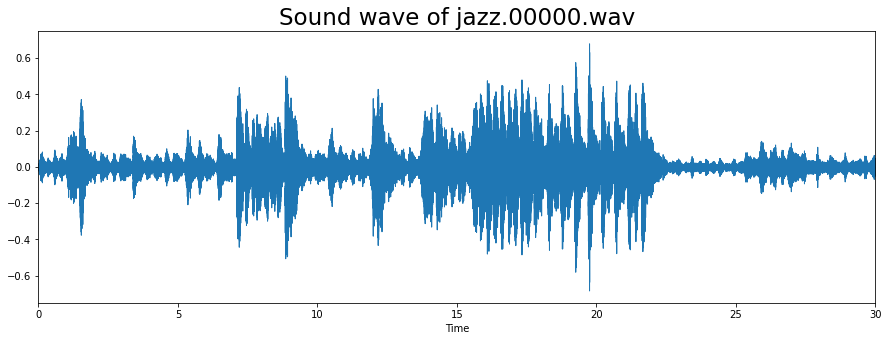

In [ ]:
y, sample_rate = librosa.load(sample_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample rate (KHz):', sample_rate, '\n')
print(f'Length of audio: {np.shape(y)[0]/sample_rate}')

# Plot th sound wave.

plt.figure(figsize=(15, 5))
librosa.display.waveplot(y=y, sr=sample_rate);
plt.title("Sound wave of jazz.00000.wav", fontsize=20);

Shape of D object: (1025, 1293)


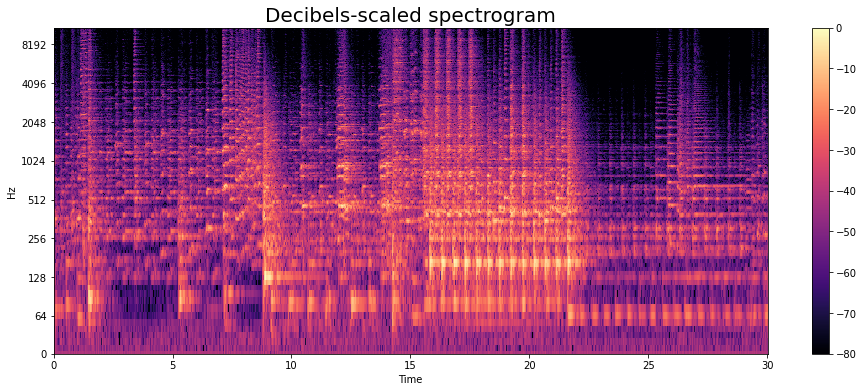

In [ ]:
# Convert sound wave to spectrogram. 

# Short-time Fourier transform (STFT).

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.

DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512, x_axis='time', y_axis ='log')
plt.colorbar();
plt.title('Decibels-scaled spectrogram', fontsize=20);

The mel spectrogram uses mel sclae intead of a linear one: [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments. 

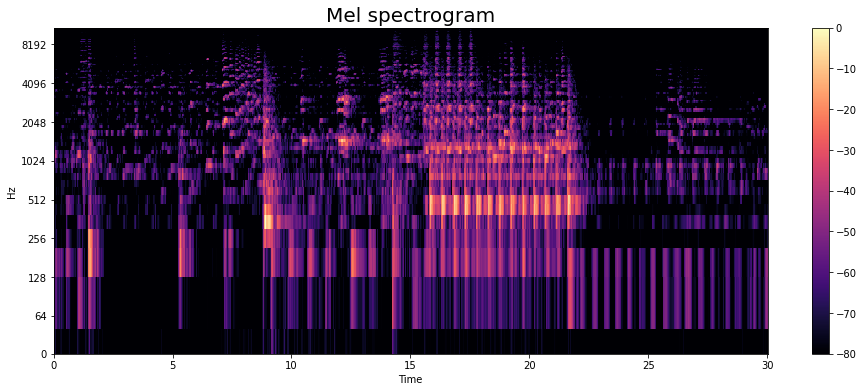

In [ ]:
# Convert sound wave to mel spectrogram.
 
y, sr = librosa.load(sample_path)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar();
plt.title("Mel spectrogram", fontsize=20);

(288, 432, 4)


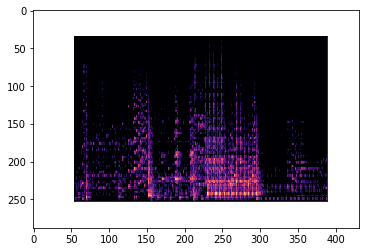

In [ ]:
# Visualize the mel spectrogram of the same sample from the dataset. 

img_path = 'Data/images_original/jazz/jazz00000.png'
img = imageio.imread(img_path)
print(img.shape)

plt.imshow(img, interpolation='nearest')
plt.show()


----
## Train a simple CNN 

In [ ]:
#@title Helper functions (run me).

def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
            "if possible, in the menu under `Runtime` -> "
            "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

DEVICE = set_device()


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    #plt.show()

In [ ]:
# Create folder with training, testing and validation data.

spectrograms_dir = "Data/images_original/"
folder_names = ['Data/train/','Data/test/','Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
    # find all images & split in train, test, and validation
    src_file_paths= []
    for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
        src_file_paths.append(im)
    random.shuffle(src_file_paths)
    test_files = src_file_paths[0:10]
    val_files = src_file_paths[10:20]
    train_files = src_file_paths[20:]

    #  make destination folders for train and test images
    for f in folder_names:
        if not os.path.exists(os.path.join(f + f"{g}")):
            os.mkdir(os.path.join(f + f"{g}"))

    # copy training and testing images over
    for f in train_files:
        shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
    for f in test_files:
        shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
    for f in val_files:
        shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [ ]:
# Data loading.

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)


In [ ]:
# Make a CNN & train it to predict genres.

class music_net(nn.Module):
    def __init__(self):
        """Intitalize neural net layers"""
        super(music_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=9856, out_features=10)

        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)
        self.batchnorm4 = nn.BatchNorm2d(num_features=64)
        self.batchnorm5 = nn.BatchNorm2d(num_features=128)

        self.dropout = nn.Dropout(p=0.3, inplace=False)


    def forward(self, x):   
        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 4.
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 5.
        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Fully connected layer 1.
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.softmax(x)

        return x
        

def train(model, device, train_loader, validation_loader, epochs):
    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            # keep track of the running loss
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                # getting the training set
                data, target = data.to(device), target.to(device)
                # Get the model output (call the model with the data from this batch)
                output = model(data)
                # Zero the gradients out)
                optimizer.zero_grad()
                # Get the Loss
                loss  = criterion(output, target)
                # Calculate the gradients
                loss.backward() 
                # Update the weights (using the training step of the optimizer)
                optimizer.step() 

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss  # add the loss for this batch

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # append the loss for this epoch
            train_loss.append(running_loss/len(train_loader))  
            train_acc.append(correct/total)

            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            
            for data, target in validation_loader:
                # getting the validation set
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)

    return train_loss, train_acc, validation_loss, validation_acc

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


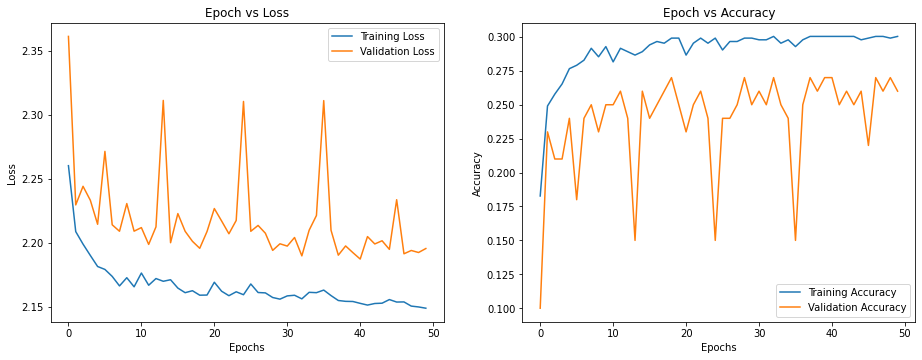

In [ ]:
# Run training. 

net = music_net().to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, val_loader, 50)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

------

-----

-----